# Smart Customer Support Workflow with LangGraph


# Overview

This project illustrates how to build a dynamic, AI-driven customer support system using LangGraph, a graph-based orchestration tool, integrated with OpenAI's language models. The system can categorize, analyze sentiment, respond appropriately, or escalate issues in real-time, providing a scalable solution for modern customer service challenges.

# Key Highlights

Intelligent Routing: Queries are automatically classified into categories (Technical, Billing, General), and routed accordingly.

Emotion-aware Responses: Sentiment analysis helps determine the tone of queries (Positive, Neutral, Negative), enabling tailored responses or escalations.

Flexible Workflow Design: The graph-based approach allows extensibility and easy visualization of complex workflows, promoting transparency and collaborative development.

Automation & Escalation: Critical or negative queries are escalated to human agents, ensuring seamless support continuity

# Demo Flow

Customer query enters the system.

The system categorizes and assesses sentiment.

Based on results, it delivers tailored responses or escalates.

Maintains a transparent process flow with visual diagrams and logs.

# Technical Architecture

Environment Setup: Utilizes dotenv for secret management, avoiding hardcoded API keys.

State Management: Using TypedDict to structure interaction states.

Node Functions: Dedicated functions for categorization, sentiment analysis, and response generation, powered by OpenAI models.

Graph Construction: Edges define the flow, with conditional routing based on real-time analysis.

Visualization: Mermaid.js diagram generation for workflow clarity.

# Why It Matters

This approach empowers businesses to:

Reduce response times with automated workflows.

Improve customer satisfaction through emotionally intelligent interactions.

Scale support operations without proportional increase in staffing.

Visualize and iterate workflows easily with integrated diagrams.

# How to Present This

Use visual diagrams to show the workflow architecture.

Highlight sample interactions illustrating different customer scenarios.

Emphasize scalability and customization options.

Demonstrate potential integrations with existing support systems.

# Import necessary libraries

In [62]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os

# Load environment variables and set OpenAI API key

In [63]:
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path='C:/Users/SATYA/Downloads/dot.env')

api_key = os.getenv('OPENAI_API_KEY')

We define a State class to hold the query, category, sentiment, and response for each customer interaction.

In [56]:
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

These functions represent the different stages of processing a customer query.

In [57]:
def categorize(state: State) -> State:
    """Categorize the customer query into Technical, Billing, or General."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}

def analyze_sentiment(state: State) -> State:
    """Analyze the sentiment of the customer query as Positive, Neutral, or Negative."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    sentiment = chain.invoke({"query": state["query"]}).content
    return {"sentiment": sentiment}

def handle_technical(state: State) -> State:
    """Provide a technical support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_billing(state: State) -> State:
    """Provide a billing support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_general(state: State) -> State:
    """Provide a general support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def escalate(state: State) -> State:
    """Escalate the query to a human agent due to negative sentiment."""
    return {"response": "This query has been escalated to a human agent due to its negative sentiment."}

def route_query(state: State) -> str:
    """Route the query based on its sentiment and category."""
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    else:
        return "handle_general"

Here we set up the LangGraph, defining nodes and edges to create our customer support workflow.

In [58]:
# Create the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

# Add edges
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

# Set entry point
workflow.set_entry_point("categorize")

# Compile the graph
app = workflow.compile()

This cell generates and displays a visual representation of our LangGraph workflow.

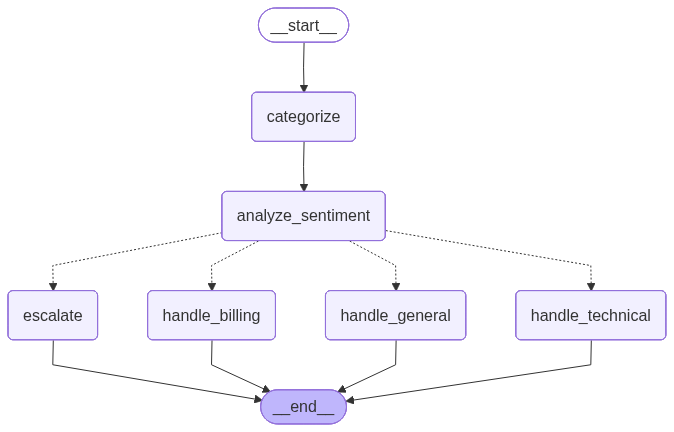

In [59]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

This function processes a customer query through our LangGraph workflow.

In [60]:
def run_customer_support(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.
    
    Args:
        query (str): The customer's query
        
    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }

Let's test our customer support agent with a sample queries for each kind of query type.

In [61]:
# escalate
query = "My internet connection keeps dropping frequently. Can you assist?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}\n")

# handle_technical
query = "I need help with how to talk to ChatGPT and use it effectively."
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}\n")

# handle_billing
query = "Can you tell me where to find my purchase receipt in the account?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}\n")

# handle_general
query = "Could you please share your business operating hours?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")


Query: My internet connection keeps dropping frequently. Can you assist?
Category: Technical
Sentiment: Negative
Response: This query has been escalated to a human agent due to its negative sentiment.

Query: I need help with how to talk to ChatGPT and use it effectively.
Category: Technical
Sentiment: Neutral
Response: Hello,

Thank you for reaching out for assistance with using ChatGPT effectively. To communicate with ChatGPT, you can simply type your message or question into the chat interface provided. ChatGPT will then generate a response based on the input it receives.

Here are some tips to help you use ChatGPT effectively:

1. Be clear and concise: Provide ChatGPT with clear and specific information to help it generate accurate responses.

2. Ask questions: Engage with ChatGPT by asking questions or providing prompts to guide the conversation.

3. Provide context: Give ChatGPT context for better understanding and more relevant responses.

4. Experiment with different prompts: T